In [2]:
!nvidia-smi

Wed Oct 21 09:20:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:08:00.0 Off |                  N/A |
| 32%   47C    P8    10W / 250W |     68MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os

In [3]:
os.getcwd()

'/home/dhruv/soundHAR'

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [22]:
import numpy as np
import vggish_params
import vggish_keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.layers import LSTM, Dense, Reshape
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm, trange

In [4]:
checkpoint_path = 'vggish_weights.ckpt'

In [5]:
sfreq = 16000

In [6]:
features = pickle.load(open('featurized_data/default_config/X_{}.pkl'.format(sfreq), 'rb'))

In [7]:
labels = pickle.load(open('featurized_data/default_config/y_{}.pkl'.format(sfreq), 'rb'))

In [8]:
features = np.array(np.concatenate(features))
labels = np.array(np.concatenate(labels))

In [9]:
features = np.array([batch for batch in features if len(batch)!=0])
labels = np.array([batch for batch in labels if len(batch)!=0])

In [10]:
labels[0]

['baby-cry',
 'baby-cry',
 'baby-cry',
 'baby-cry',
 'baby-cry',
 'baby-cry',
 'baby-cry',
 'baby-cry',
 'baby-cry']

In [11]:
flat_labels = np.concatenate(labels)
flat_labels.shape

(109156,)

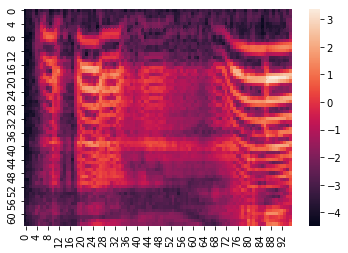

In [12]:
sns.heatmap(features[0][0].T)

In [248]:
# selected_labels = ['alarm-clock','buzzer', 'cough', 'dishwasher','doorbell',
#                    'gargle','shaver','toothbrush','typing','write']

In [104]:
# features_s = []
# labels_s = []
# for label in selected_labels:
#     idx = np.where(labels == label)[0]
#     features_s.append(features[idx])
#     labels_s.append(labels[idx])

In [105]:
# features_s = np.vstack(features_s)
# labels_s = np.concatenate(labels_s)

In [106]:
# features = features_s
# labels = labels_s

In [13]:
# Preprocess data
# length_batches = len(labels)//64 * 64
# features = features[:length_batches]
# labels = labels[:length_batches]

weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_labels),
                                            flat_labels)
class_weights = dict(enumerate(weights))

/home/dhruv/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=['alarm-clock' 'baby-cry' 'blender' 'car-horn' 'cat-meow' 'chopping'
 'cooking' 'cough' 'dishwasher' 'dog-bark' 'door' 'doorbell' 'drill'
 'engine' 'flush' 'hair-dryer' 'hammer' 'hazard-alarm' 'knock' 'laugh'
 'microwave' 'phone-ring' 'saw' 'shaver' 'snore' 'speech' 'toothbrush'
 'typing' 'vacuum' 'water-running'], y=['baby-cry' 'baby-cry' 'baby-cry' ... 'cat-meow' 'cat-meow' 'cat-meow'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [14]:
class_weights

{0: 2.60639923591213,
 1: 1.4070121165248775,
 2: 3.4851851851851854,
 3: 7.725123849964614,
 4: 7.611994421199442,
 5: 3.275007500750075,
 6: 1.0200542005420055,
 7: 4.59991571849979,
 8: 1.3018008348240906,
 9: 1.144552794379784,
 10: 4.394363929146538,
 11: 9.073649210307565,
 12: 1.7950337115605985,
 13: 0.2725084881166367,
 14: 1.7211605171870072,
 15: 2.6195344372450204,
 16: 1.3092959097996881,
 17: 0.626253585771658,
 18: 5.739011566771819,
 19: 2.451841868823001,
 20: 1.4778770647170323,
 21: 0.951748190775133,
 22: 2.0827323029956117,
 23: 2.0013934726806015,
 24: 3.972197962154294,
 25: 0.15628096097127966,
 26: 6.826516572858036,
 27: 0.9033101621979477,
 28: 0.6507839980921719,
 29: 0.21761562998405104}

In [15]:
ohe = OneHotEncoder()
ohe.fit(flat_labels.reshape((-1,1)))

NUM_CLASSES = len(weights)

features = [batch.reshape((-1,vggish_params.NUM_FRAMES,vggish_params.NUM_BANDS, 1)) for batch in features]
labels = [ohe.transform(np.array(batch).reshape((-1,1))).toarray() for batch in labels]
# labels = labels.reshape((-1, NUM_CLASSES))

In [16]:
len(features)

19287

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
del features, labels

In [18]:
len(y_train)

15429

In [37]:
# Define VGGish, load the checkpoint, and run the batch through the model to
# produce embeddings.
vggish = vggish_keras.get_vggish_keras(use_with_lstm=True)
vggish.load_weights(checkpoint_path)

x = vggish.output
x = Reshape((1, -1))(x)
x = LSTM(units = 128, stateful=True, name='lstm')(x)
x = Dense(NUM_CLASSES, activation='sigmoid', name='prediction')(x)
model = Model(vggish.input, x, name='model')

In [38]:
optimizer = SGD(learning_rate=0.001, momentum=0.9)
loss_fn = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, 
              metrics=['accuracy'])

# model.load_weights('checkpoints/model_{}.h5'.format(sfreq))

checkpoint = ModelCheckpoint('checkpoints/model_lstm_{}.h5'.format(sfreq), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [125]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 96, 64, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       590080

In [36]:
history = model.fit(np.concatenate(X_train), np.concatenate(y_train), epochs=5, batch_size=1, 
                    validation_data=(np.concatenate(X_test), np.concatenate(y_test)),
                    class_weight=class_weights, callbacks= [earlystopping], shuffle=False)

Epoch 1/5
68436/86070 [======================>.......] - ETA: 3:05 - loss: 0.1170 - accuracy: 0.2864

KeyboardInterrupt: 

In [119]:
np.concatenate(y_train).shape

(86070, 30)

In [ ]:
history = {
    'train': [],
    'test': []
}

max_acc = 0
for epoch in range(100):
    
    # Training
    num_batches = len(X_train) 
    t = trange(num_batches, desc='epoch {}: Train'.format(epoch+1))
    for i in t:
        X_batch = X_train[i]
        y_batch = y_train[i]
        num_samples = len(X_batch)
        for j in range(num_samples):
            X = X_batch[j:j+1]
            y = y_batch[j:j+1]
            metrics = model.train_on_batch(X, y, class_weight=class_weights, reset_metrics=False, return_dict=True)
        lstm = model.get_layer('lstm')
        lstm.reset_states()
        t.set_postfix(metrics)
    history['train'].append(metrics)
    
    # Testing
    num_batches = len(X_test) 
    t = trange(num_batches, desc='epoch {}: Test'.format(epoch+1))
    for i in t:
        X_batch = X_test[i]
        y_batch = y_test[i]
        num_samples = len(X_batch)
        for j in range(num_samples):
            X = X_batch[j:j+1]
            y = y_batch[j:j+1]
            metrics = model.test_on_batch(X, y, reset_metrics=False, return_dict=True)
        lstm = model.get_layer('lstm')
        lstm.reset_states()
        t.set_postfix(metrics)
    history['test'].append(metrics)
    
    if max_acc < metrics['accuracy']:
        print('val accuracy improved from {} to {}. saving model...'.format(max_acc, metrics['accuracy']))
        max_acc = metrics['accuracy']
        model.save('checkpoints/model_lstm_{}.h5'.format(sfreq))
        
    print('')

epoch 1: Test: 100%|██████████| 3858/3858 [01:22<00:00, 46.88it/s, loss=0.144, accuracy=0.0722]


val accuracy improved from 0 to 0.07222690433263779. saving model...


epoch 2: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.144, accuracy=0.0722]

epoch 2: Test: 100%|██████████| 3858/3858 [01:21<00:00, 47.06it/s, loss=0.142, accuracy=0.0771]


val accuracy improved from 0.07222690433263779 to 0.07711898535490036. saving model...


epoch 3: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.142, accuracy=0.0771]

epoch 3: Test: 100%|██████████| 3858/3858 [01:21<00:00, 47.62it/s, loss=0.14, accuracy=0.0805] 


val accuracy improved from 0.07711898535490036 to 0.08049030601978302. saving model...


epoch 4: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.14, accuracy=0.0805]

epoch 4: Test: 100%|██████████| 3858/3858 [01:23<00:00, 46.44it/s, loss=0.138, accuracy=0.0925]


val accuracy improved from 0.08049030601978302 to 0.09245483577251434. saving model...


epoch 5: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.138, accuracy=0.0925]

epoch 5: Test: 100%|██████████| 3858/3858 [01:23<00:00, 46.31it/s, loss=0.136, accuracy=0.105]


val accuracy improved from 0.09245483577251434 to 0.105300672352314. saving model...


epoch 6: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.136, accuracy=0.105]

epoch 6: Test: 100%|██████████| 3858/3858 [01:23<00:00, 46.12it/s, loss=0.134, accuracy=0.119]


val accuracy improved from 0.105300672352314 to 0.11946510523557663. saving model...


epoch 7: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.134, accuracy=0.119]

epoch 7: Test: 100%|██████████| 3858/3858 [01:22<00:00, 46.84it/s, loss=0.132, accuracy=0.133]


val accuracy improved from 0.11946510523557663 to 0.13317245244979858. saving model...


epoch 8: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.132, accuracy=0.133]

epoch 8: Test: 100%|██████████| 3858/3858 [01:22<00:00, 46.97it/s, loss=0.13, accuracy=0.148] 


val accuracy improved from 0.13317245244979858 to 0.14789612591266632. saving model...


epoch 9: Train:   0%|          | 0/15429 [00:00<?, ?it/s, loss=0.13, accuracy=0.148]

epoch 9: Train:  70%|███████   | 10804/15429 [23:46<10:50,  7.11it/s, loss=0.129, accuracy=0.156]  

In [154]:
num_batches

17358

In [151]:
history

{'loss': 0.6131810545921326, 'accuracy': 0.03703703731298447}

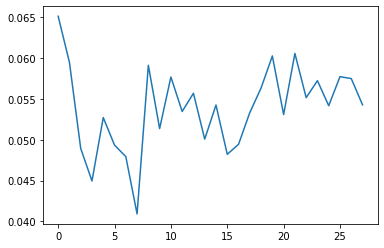

In [257]:
plt.plot(history.history['val_loss'])

### Contextual Results

In [258]:
model.load_weights('checkpoints/model_{}.h5'.format(sfreq))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [259]:
labels_test = ohe.inverse_transform(y_test).flatten()

In [260]:
pred = model.predict(X_test)

In [261]:
np.unique(labels_test)

array(['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'], dtype='<U32')

In [262]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(labels_test)}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [263]:
for context in contexts.keys():
    valid_idx = [i for i, label in enumerate(labels_test) if label in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = np.argmax(valid_pred * context_encoding[context], axis=1)
    valid_pred = [ohe.categories_[0][pr] for pr in valid_pred]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    print('{}, {}, {}, {}'.format(sfreq, context, acc, f1))

16000, monolithic, 0.8145840967387321, 0.8171203060664867
16000, bathroom, 0.9351351351351351, 0.9349710717558156
16000, kitchen, 0.8740410347903658, 0.8736329104045493
16000, bedroom, 0.9120992761116856, 0.9170344820397134
16000, office, 0.8933130699088145, 0.8944467813050009
16000, entrance, 0.9051593323216995, 0.9038783638662549
16000, workshop, 0.9133935106123445, 0.912446504321971
16000, outdoor, 0.9198203976908275, 0.9226780532429633
